In [1]:
import numpy as np
import pandas as pd
import math

PLOT_VISUALIZATIONS = True
RANDOM_SEED = 1243
TEST_SIZE = 0.1

In [2]:
import sys
from importlib import reload
customPackages = ["visualizations", "modelling"]
for pkg in customPackages:
    reload(sys.modules[pkg]) if pkg in sys.modules else __import__(pkg)
    
vis = sys.modules["visualizations"].Visualizations()
mod = sys.modules["modelling"].Modelling(vis=vis)

In [3]:
rawData = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
print(rawData.shape)
rawData.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data cleansing steps

1. Drop id column
2. Convert all categorical columns into 1-hot vectors (gender, ever_married, work_type, Residence_type, smoking_status)
3. Fill NaN values
4. Normalize numerical columns (age, avg_glucose_level, bmi)

In [4]:
TARGET_COLUMN = "stroke"

In [5]:
rawData.drop(columns="id", inplace=True)

In [6]:
print("There are only %d rows with Gender = Other. Dropping these to reduce noise!" % rawData[rawData["gender"] == "Other"].shape[0]) 
rawData = rawData[rawData["gender"] != "Other"]

There are only 1 rows with Gender = Other. Dropping these to reduce noise!


In [7]:
rawData["ever_married"] = rawData["ever_married"].apply(lambda x: "married" if x == "Yes" else "not_married")

binaryColumns = ["gender", "Residence_type", "ever_married"]
for col in binaryColumns:
    trueValue = rawData[col].unique()[0]
    rawData["is_" + trueValue.lower()] = rawData[col].apply(lambda x: 1 if x == trueValue else 0)
rawData.drop(columns=binaryColumns, inplace=True)

uniqueCounts = rawData.apply(lambda x: len(np.unique(x)), axis=0)
binaryColumns = np.array(uniqueCounts[uniqueCounts == 2].index)
binaryColumns = binaryColumns[binaryColumns != TARGET_COLUMN]

There are 5 True/False or binary columns in the dataset.
['hypertension' 'heart_disease' 'is_male' 'is_urban' 'is_married']


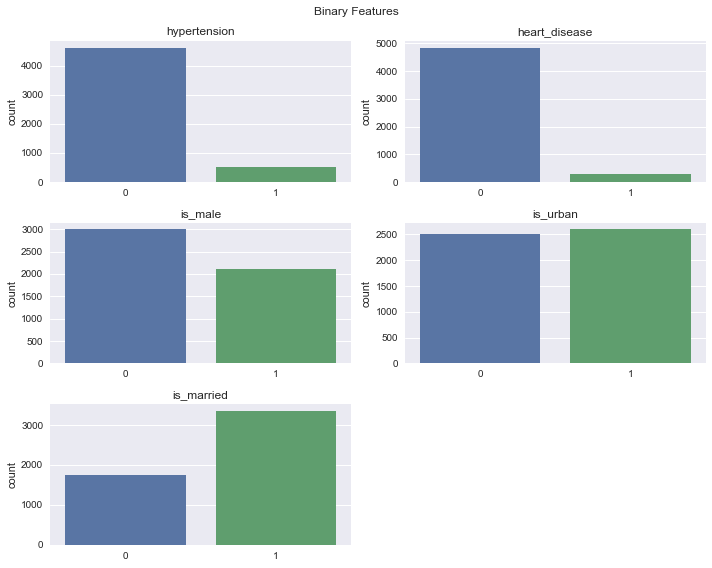

In [8]:
print("There are %d True/False or binary columns in the dataset." % len(binaryColumns))
print(binaryColumns)

if PLOT_VISUALIZATIONS:
    vis.plotMultipleCountPlots(data=rawData, columns=binaryColumns, figSize=(10,8), plotTitle="Binary Features")

There are 3 numeric columns in the dataset.
['age', 'avg_glucose_level', 'bmi']


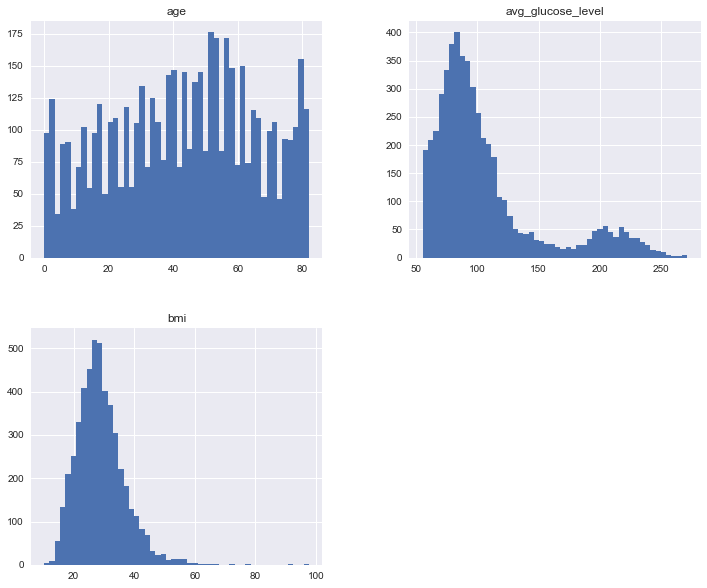

In [9]:
numericColumns = list(rawData.columns[rawData.dtypes == float])
print("There are %d numeric columns in the dataset." % len(numericColumns))
print(numericColumns)

if PLOT_VISUALIZATIONS:
    vis.plotHistograms(rawData[numericColumns], figSize=(12,10))

There are 2 True/False or binary columns in the dataset.
['work_type', 'smoking_status']


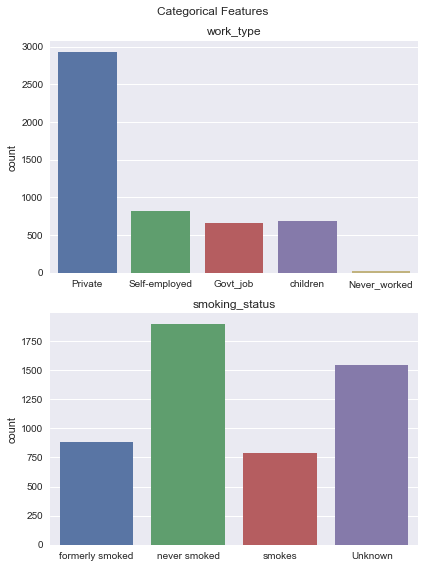

In [10]:
categoryColumns = list(rawData.columns[rawData.dtypes == object])
print("There are %d True/False or binary columns in the dataset." % len(categoryColumns))
print(categoryColumns)

if PLOT_VISUALIZATIONS:    
    vis.plotMultipleCountPlots(data=rawData, columns=categoryColumns, figSize=(6,8), plotTitle="Categorical Features")

In [11]:
print("There are %d null values in the raw data." % (rawData.isnull().values.sum()))
rawData.isnull().sum(axis = 0)

There are 201 null values in the raw data.


age                    0
hypertension           0
heart_disease          0
work_type              0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
is_male                0
is_urban               0
is_married             0
dtype: int64

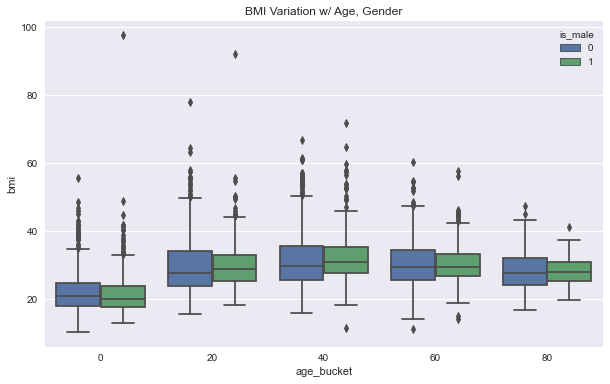

In [12]:
rawData["age_bucket"] = rawData["age"].apply(lambda x: 20 * math.floor(x / 20))
if PLOT_VISUALIZATIONS:
    vis.plotBoxPlot(data=rawData, x="age_bucket", y="bmi", hue="is_male", figSize=(10,6), plotTitle="BMI Variation w/ Age, Gender")

In [13]:
y = rawData[TARGET_COLUMN]
X = rawData.drop(columns=TARGET_COLUMN)
X_train, X_test, y_train, y_test = mod.splitData(X, y, testSize=TEST_SIZE, randomSeed=RANDOM_SEED, resetIndex=True)

In [14]:
X_train_preproc, encoderModels, imputerModel, scalerModel = mod.preprocData(X=X_train, categoryColumns=categoryColumns, numericColumns=numericColumns)
X_train_preproc.head()

,hypertension,heart_disease,is_male,is_urban,is_married,age_bucket,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes,age,avg_glucose_level,bmi
0,0.0,0.0,0.0,1.0,1.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.285714,-1.003211,-0.119565
1,0.0,0.0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.028571,0.070506,-0.358696
2,1.0,0.0,1.0,0.0,1.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.371429,3.588440,1.445652
3,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.600000,0.627998,-0.521739
4,0.0,0.0,1.0,0.0,1.0,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.216438,0.804348


In [15]:
X_test_preproc, _, _, _ = mod.preprocData(X=X_test, categoryColumns=categoryColumns, numericColumns=numericColumns, \
    encoderModels=encoderModels, imputerModel=imputerModel, scalerModel=scalerModel)